# This notebook provides a slider to compare different physics parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/4_analysis_variables_plots/')
!mkdir -p $save_folder
save_folder = (f'../fig/4_analysis_variables_plots/{hierarchy}_{D_or_M}_')

set_plot_style()

## Use this to load the datasets in the usual way and dump them in pickle files

In [4]:
# my_exp_analyses = load_datasets(hierarchy, D_or_M, 
#                                 timeit=True, 
#                                 direct_load_objects=False,
#                                 dump=True,
#                                 load_grid=False)

## Use the function this way to load the datasets from the pickle files

In [5]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=True,
                                load_grid=False)

heavy dirac FHC
Wall time: 11.160976648330688 s, CPU time: 1.3860518309999996
heavy dirac RHC
Wall time: 11.132266283035278 s, CPU time: 1.3572018559999997


# A plot of the detector

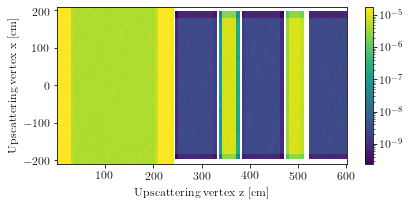

In [44]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']
df = exp_analysis_obj.df_base

this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
                            ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
                            pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(df['int_point_z'], df['int_point_x'], 
          bins=(100, 30), weights=this_weights, norm=LogNorm(),
          density=True);
plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

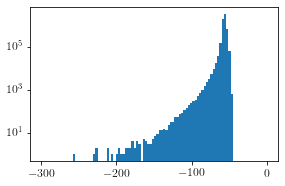

In [40]:
plt.hist(np.log10(df['generator_weight']), range=[-300, 0], bins=100)
plt.yscale('log')

In [10]:
tpc_masses

{'hydrogen': 0.5507270215029775,
 'oxygen': 3.420920851265022,
 'carbon': 9.722023965952,
 'copper': 0.8679,
 'zinc': 0.4471,
 'lead': 3.634,
 'argon': 0.01602}

In [6]:
ctaus = np.array([0.5, 0.2, 0.1])

nu_mode = 'FHC'
aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=ctaus,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=None,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


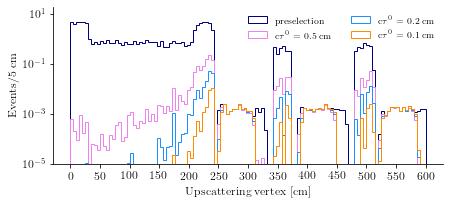

In [ ]:
fig = plt.figure(figsize=(7,2.9))

binning = np.linspace(0, 600, 120)
bin_width = binning[1]-binning[0]

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.hist(aux_noctau[0]['int_point_z'],
         bins=binning,
         weights=aux_noctau[1]/bin_width,
         histtype='step',
         color='navy',
         label='preselection')

colors = ['violet', 'dodgerblue', 'darkorange']
for i, ctau in enumerate(ctaus):
    plt.hist(aux[0]['int_point_z'],
             bins=binning,
             weights=aux[1][:, i]/bin_width,
             histtype='step',
             color=colors[i],
             label=f'c$\\tau^0$ = {ctau:.3g} cm')
plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 2e1)
plt.ylabel(f'Events/{bin_width:.2g} cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
# plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')

In [21]:
aux[1][aux[0]['hydrogen'], 1].sum()

0.027754867424441113

In [20]:
aux[1][aux[0]['carbon'], 1].sum()

0.4500983898920141

In [19]:
aux[1][aux[0]['lead'], 1].sum()

0.4708709735803924

In [23]:
aux[1][aux[0].eval('carbon & (int_point_z < 240)'), 1].sum()

0.2771045215623564

In [24]:
aux[1][aux[0].eval('carbon & (int_point_z > 240)'), 1].sum()

0.17299386832965774

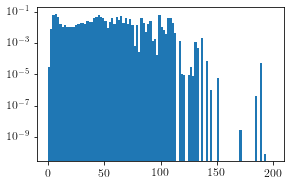

In [32]:
plt.hist(aux[0]['betagamma'], weights=aux[1][:, 1], bins=100, range=(0,200))
plt.yscale('log')

In [ ]:
plt.hist(aux[0]['betagamma'], bins=100)

# Plot 1d distribution analysis for the light case

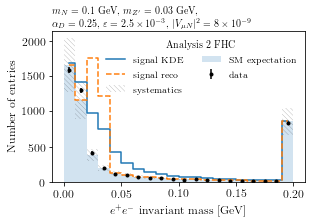

In [56]:
nu_mode = 'FHC'
this_analysis = analyses['nueccqe_fgd'][nu_mode]
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']

ax = set_canvas_basic()

this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] *= 15
plot_data_from_analysis(ax=ax,
                        analysis=this_analysis,
                        plot_data=True)

out = exp_analysis_obj.compute_expectation(
                                exp_analysis_obj.df_base, 
                                m4=this_point['m4'], 
                                mz=this_point['mz'], 
                                alpha_dark=this_point['alpha_dark'], 
                                epsilon=this_point['epsilon'], 
                                Umu4_2=this_point['Umu4_2'], 
                                Ud4_2=this_point['Ud4_2'],
                                ntarget_per_material=this_analysis['n_target'], 
                                pot=this_analysis['pot'],
                                selection_query=this_analysis['selection'],
                                efficiency_factor=this_analysis['efficiency'])
aux_df = out[0]
all_weights = out[1]

bin_centers = (this_analysis['binning'][1:]+this_analysis['binning'][:-1])/2
hist_signal, _ = np.histogram(aux_df[this_analysis['var']], 
                              bins=this_analysis['binning'], weights=all_weights)
ax.step(bin_centers, (this_analysis['mc'] + hist_signal), where='mid', label='signal reco')

hist_signal, _ = np.histogram(aux_df['ee_mass'], 
                              bins=this_analysis['binning'], weights=all_weights)
ax.step(bin_centers, (this_analysis['mc'] + hist_signal), where='mid', label='signal KDE', ls='--')

ax.legend(frameon=False, ncol=2, title=f'Analysis-II {nu_mode}')
ax.set_xlabel(r'$e^+e^-$ invariant mass [GeV]')
set_plot_title(ax, 
               **this_point
               )
plt.savefig(save_folder+'ee_mass_distribution_fgd_fhc.pdf', bbox_inches='tight')

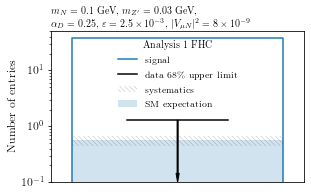

In [57]:
nu_mode = 'FHC'
this_analysis = analyses['tpc_light'][nu_mode]
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']

ax = set_canvas_basic()

this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] *= 15
plot_data_from_analysis(ax=ax,
                        analysis=this_analysis,
                        plot_data=False)

out = exp_analysis_obj.compute_expectation(
                                exp_analysis_obj.df_base, 
                                m4=this_point['m4'], 
                                mz=this_point['mz'], 
                                alpha_dark=this_point['alpha_dark'], 
                                epsilon=this_point['epsilon'], 
                                Umu4_2=this_point['Umu4_2'], 
                                Ud4_2=this_point['Ud4_2'],
                                ntarget_per_material=this_analysis['n_target'], 
                                pot=this_analysis['pot'],
                                selection_query=this_analysis['selection'],
                                efficiency_factor=this_analysis['efficiency'])
all_weights = out[1]
ax.step([-1, 1, 2], np.array([0, (this_analysis['mc'] + all_weights.sum())[0], 0]), where='pre', label='signal expectation')

ax.axhline(1.29, 0.3, 0.7, color='black', label='data 68\% upper limit')
ax.arrow(0., 1.29, 0, -1.19, width=0.01, color='black', length_includes_head=True)

ax.legend(frameon=False, title=f'Analysis-I {nu_mode}')
ax.xaxis.set_visible(False)
ax.set_xlabel('One bin')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0.1, 50)
ax.set_yscale('log')
set_plot_title(ax, 
               **this_point
               )
plt.savefig(save_folder+'ee_mass_distribution_tpc_fhc.pdf', bbox_inches='tight')

# Find the c$\tau$ we exclude by varying $V_{ND}$

In [6]:
from ctau_utils import ctau_heavy
from const import alphaQED

In [7]:
V_N_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1e2, 25)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['Ud4_2'] = V_N_2_s

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

leff = np.zeros(V_N_2_s.shape)
mu_s = np.zeros(V_N_2_s.shape)
sigma2_s = np.zeros(V_N_2_s.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff -= leff.min()

In [8]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-2, 1], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)
r2 = root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
                 fprime=None, fprime2=None, x0=1e4, x1=2e4)

(-1.0, 1.0)

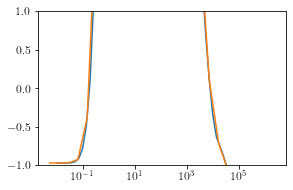

In [9]:
plt.plot(np.geomspace(1e-2, 1e5, 50), like_interp(np.geomspace(1e-2, 1e5, 50)))
plt.plot(ctaus, leff-likelihood_levels_1d[0.9])
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1, 1)

<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


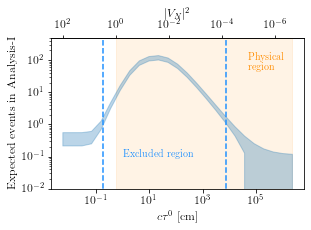

In [10]:
from scipy.interpolate import UnivariateSpline

ax = set_canvas_basic()
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')

forward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)
backward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$|V_N|^2$')
secax.set_ticks

ax.fill_betweenx([1e-2, 1e4], 
                 backward(physics_parameters['heavy']['bp']['Umu4_2']), backward(1), 
                 color='darkorange', alpha=0.1)
ax.annotate('Physical\n region', color='darkorange', xy=(5e4, 5e1))

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='dodgerblue', ls='--')
ax.vlines(r2.root, 0, 1e4, color='dodgerblue', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
ax.set_ylim(1e-2, 5e2)

# plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.pdf', bbox_inches='tight')
plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.png', bbox_inches='tight', transparent=True, dpi=500)

## for different $m_N$

In [10]:
V_N_2_s = np.geomspace(1e-2, 1e1, 10)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['m4'] = np.linspace(0.04, 0.2, 17)
this_point['m4'] = this_point['m4'].reshape(len(this_point['m4']), 1)
this_point['Ud4_2'] = V_N_2_s.reshape(1, len(V_N_2_s))

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

aux = {}
for nu_mode in ['FHC', 'RHC']:
    aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)

leff = aux['FHC'][0] + aux['RHC'][0]
mu_s = aux['FHC'][1] + aux['RHC'][1]
sigma2_s = aux['FHC'][3] + aux['RHC'][3]

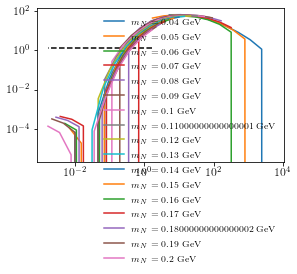

In [12]:
for i, m4 in enumerate(np.squeeze(this_point['m4'])):
    leff[i,:] -= np.min(leff[i,:])
    plt.plot(ctaus[i,:], leff[i,:], label=f'$m_N$ = {m4} GeV')
plt.loglog()
plt.hlines(likelihood_levels_1d[0.9], ctaus[-1,0], ctaus[-1,-1], color='k', ls='--')
plt.legend()

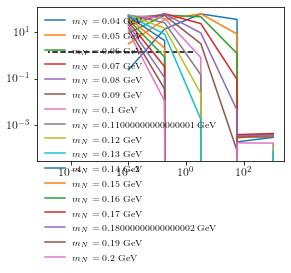

In [9]:
for i, m4 in enumerate(np.squeeze(this_point['m4'])):
    leff[i,:] -= np.min(leff[i,:])
    plt.plot(np.squeeze(this_point['Ud4_2']), leff[i,:], label=f'$m_N$ = {m4} GeV')
plt.loglog()
plt.hlines(likelihood_levels_1d[0.9], ctaus[-1,0], ctaus[-1,-1], color='k', ls='--')
plt.legend()

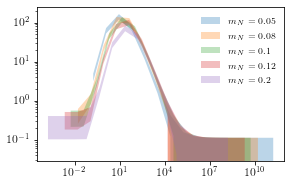

In [34]:
for i, m4 in enumerate(np.squeeze(this_point['m4'])):
    plt.fill_between(ctaus[i,:], 
                     mu_s[i,:]-np.sqrt(sigma2_s[i,:]),
                     mu_s[i,:]+np.sqrt(sigma2_s[i,:]),
                     label=f'$m_N$ = {m4} GeV',
                     alpha=0.3)
plt.loglog()
plt.legend()

In [16]:
# V_N_2_s = np.geomspace(1e-2, 1e1, 10)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['m4'] = np.linspace(0.01, 0.2, 20)
# this_point['m4'] = this_point['m4'].reshape(len(this_point['m4']), 1)
# this_point['Ud4_2'] = V_N_2_s.reshape(1, len(V_N_2_s))

# ctaus = ctau_heavy(m4=this_point['m4'],
#                    mz=this_point['mz'], 
#                    Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
#                    D_or_M=D_or_M)
# external_ctaus = np.linspace(0.01, 1, 20)
this_point['external_ctau'] = np.linspace(0.01, 1, 20)

aux = {}
for nu_mode in ['FHC', 'RHC']:
    aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)

leff = aux['FHC'][0] + aux['RHC'][0]
mu_s = aux['FHC'][1] + aux['RHC'][1]
sigma2_s = aux['FHC'][3] + aux['RHC'][3]

TypeError: compute_likelihood_from_pars() got an unexpected keyword argument 'external_ctau'

In [14]:
r1 = []
r2 = []
for i, m4 in enumerate(np.squeeze(this_point['m4'])):
    print(m4)
    leff[i,:] -= np.min(leff[i,:])
    like_interp = interp1d(ctaus[i,:], leff[i,:]-likelihood_levels_1d[0.9], kind='cubic')
    # print(max(1e-2, ctaus[i,-1]))
    # print(like_interp([max(1e-2, ctaus[0,-1]), 1, 1e3, 1e5]))
    r1.append(root_scalar(like_interp, method='brentq', bracket=[max(1e-2, ctaus[i,-1]), 1], 
                     fprime=None, fprime2=None, x0=0.2, x1=0.15).root)
    # r2.append(root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
    #                  fprime=None, fprime2=None, x0=1e4, x1=2e4))

0.04


ValueError: A value in x_new is below the interpolation range.

In [11]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Ud4_2'] = None

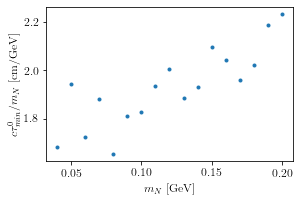

In [78]:
plt.plot(np.squeeze(this_point['m4'])[1:],
         r1/np.squeeze(this_point['m4'])[1:], 
         '.')
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min} /m_N$ [cm/GeV]')
set_plot_title(ax, 
               **this_point
               )
plt.savefig(save_folder + 'ctau_div_mn_vs_mn.pdf', bbox_inches='tight')

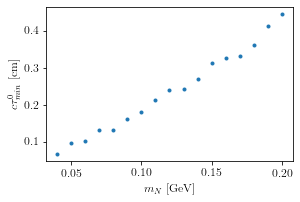

In [77]:
plt.plot(np.squeeze(this_point['m4'])[1:],
         r1, 
         '.')
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
plt.savefig(save_folder + 'ctau_vs_mn.pdf', bbox_inches='tight')

## Older plot

Text(0.5, 0, '$c\\tau$ [cm]')

<ipython-input-50-63adadc83904>:28: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


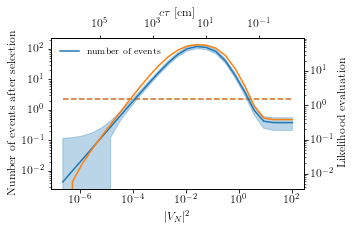

In [50]:
# from scipy.interpolate import UnivariateSpline

# ax = set_canvas_basic()
# ax2 = ax.twinx()
# ax2.set_ylabel('Likelihood evaluation')

# ax.plot(V_N_2_s, mu_s, 'C0', label='number of events')
# ax.fill_between(V_N_2_s, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
#                 color='C0', alpha=0.3)
# ax2.plot(V_N_2_s, leff, 'C1', label='negative log likelihood')

# ax.set_xlabel('$|V_N|^2$')
# ax.set_ylabel('Number of events after selection')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax2.set_yscale('log')
# ax.legend(frameon=False)
# ax.hlines(2.3, V_N_2_s[0], V_N_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

# ctaus = np.squeeze(ctaus)
# forward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)
# backward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)

# def forward(x):
#     return np.exp(forward_fun(np.log(x)))

# def backward(x):
#     return np.exp(backward_fun(np.log(x)))

# secax = ax.secondary_xaxis('top', functions=(forward, backward))
# secax.set_xlabel('$c\\tau$ [cm]')

# # plt.savefig(save_folder+'n_events_vs_V_ND.pdf', bbox_inches='tight')

# Number of events vs c$\tau$ and $V_{ND}$ on the same axis

In [8]:
U_ND_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1, 10)

mu_s = {}
sigma2_s = {}
for selection in ['lead', 'argon']:
    mu_s[selection] = np.zeros(U_ND_2_s.shape)
    sigma2_s[selection] = np.zeros(U_ND_2_s.shape)
    for nu_mode in ['FHC', 'RHC']:
        aux = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=U_ND_2_s,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        ctau = aux[3]

<ipython-input-9-d0109d33ae10>:23: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
<ipython-input-9-d0109d33ae10>:23: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-9-d0109d33ae10>:23: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-9-d0109d33ae10>:23: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


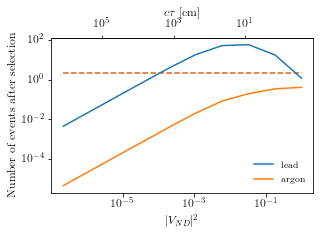

In [9]:
from scipy.interpolate import UnivariateSpline

ax = set_canvas_basic()

for selection in ['lead', 'argon']:     
    ax.plot(U_ND_2_s, mu_s[selection], label=selection)

ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)
ax.hlines(2.3, U_ND_2_s[0], U_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

ctau = np.squeeze(ctau)
forward_fun = UnivariateSpline(np.log(U_ND_2_s), np.log(ctau), k=1)
backward_fun = UnivariateSpline(np.log(ctau[::-1]), np.log(U_ND_2_s[::-1]), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$c\\tau$ [cm]')

plt.savefig(save_folder+'n_events_vs_V_ND.pdf', bbox_inches='tight')

In [6]:
ctaus = np.geomspace(1e-2, 1e4, 20)

mu_s = {}
sigma2_s = {}

mu_s_noctau = {}
sigma2_s_noctau = {}

materials = ['lead', 'argon']
for selection in materials:
    mu_s[selection] = 0
    sigma2_s[selection] = 0
    mu_s_noctau[selection] = 0
    sigma2_s_noctau[selection] = 0
    for nu_mode in ['FHC', 'RHC']:
        aux = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=ctaus,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        
        aux_noctau = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=None,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s_noctau[selection] += aux_noctau[1].sum(axis=0)
        sigma2_s_noctau[selection] += (aux_noctau[1]**2).sum(axis=0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


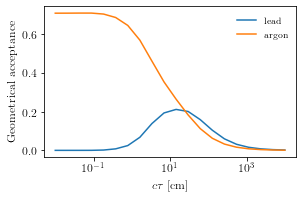

In [7]:
ax = set_canvas_basic()

for selection in materials:     
    ax.plot(ctaus, mu_s[selection]/mu_s_noctau[selection], label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.legend(frameon=False, loc='upper right')


# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

# Try again

In [8]:
ctaus = np.geomspace(1e-2, 1e4, 21)
nu_mode = 'FHC'
this_analysis = analyses['tpc'][nu_mode]

out_ctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                            my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                            m4=physics_parameters[hierarchy]['bp']['m4'], 
                            mz=physics_parameters[hierarchy]['bp']['mz'], 
                            alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                            epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                            Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                            Ud4_2=None,
                            external_ctau=ctaus,
                            ntarget_per_material=this_analysis['n_target'], 
                            pot=this_analysis['pot'],
                            selection_query=this_analysis['selection'],
                            efficiency_factor=this_analysis['efficiency'])

out_no_ctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                            my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                            m4=physics_parameters[hierarchy]['bp']['m4'], 
                            mz=physics_parameters[hierarchy]['bp']['mz'], 
                            alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                            epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                            Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                            Ud4_2=None,
                            external_ctau=None,
                            ntarget_per_material=this_analysis['n_target'], 
                            pot=this_analysis['pot'],
                            selection_query=this_analysis['selection'],
                            efficiency_factor=this_analysis['efficiency'])

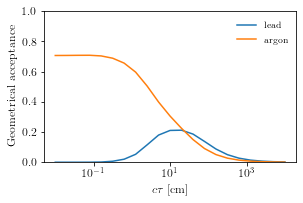

In [18]:
ax = set_canvas_basic()

for selection in ['lead', 'argon']:     
    acceptance = out_ctau[1][out_ctau[0][selection], ...].sum(axis=0)/out_no_ctau[1][out_no_ctau[0][selection], ...].sum(axis=0)
    ax.plot(ctaus, acceptance, label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.legend(frameon=False, loc='upper right')

# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

<ipython-input-81-d38e03d2ba84>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')
<ipython-input-81-d38e03d2ba84>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')
<ipython-input-81-d38e03d2ba84>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')


(0.0, 1.0)

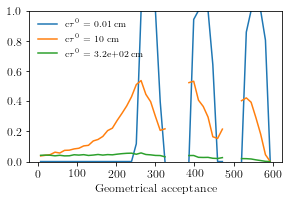

In [81]:
ax = set_canvas_basic()

ctaus_indexes = [0, 10, 15]
binning = np.linspace(0, 600, 50)
#binning = np.linspace(250.95, 329.04999999999995, 50)
bin_centers = (binning[1:] + binning[:-1])/2
hist_noctau, _ = np.histogram(out_no_ctau[0]['int_point_z'], bins=binning, weights=out_no_ctau[1])
for index in ctaus_indexes:
    hist_ctau, edges = np.histogram(out_ctau[0]['int_point_z'], bins=binning, weights=out_ctau[1][..., index])
    ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')

ax.legend(frameon=False)
ax.set_xlabel('z coordinate interaction point [cm]')
ax.set_xlabel('Geometrical acceptance')
ax.set_ylim(0, 1)

<ipython-input-57-41afa2c4d9b9>:13: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')
<ipython-input-57-41afa2c4d9b9>:13: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')
<ipython-input-57-41afa2c4d9b9>:13: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')


(0.0, 1.0)

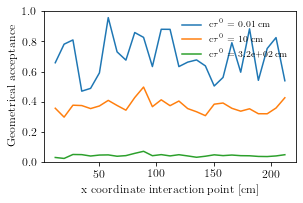

In [57]:
ax = set_canvas_basic()

selection = f'({tpc_active_volume_endpoints[2][0]}<int_point_z)&(int_point_z<{tpc_active_volume_endpoints[2][1]})'
ctaus_indexes = [0, 10, 15]
binning = np.linspace(0, p0d_dimensions[1], 30)
bin_centers = (binning[1:] + binning[:-1])/2
hist_noctau, _ = np.histogram(out_no_ctau[0].query(selection)['int_point_y'], bins=binning, 
                              weights=out_no_ctau[1][out_no_ctau[0].eval(selection)])

for index in ctaus_indexes:
    hist_ctau, edges = np.histogram(out_ctau[0].query(selection)['int_point_y'], bins=binning, 
                                    weights=out_ctau[1][out_ctau[0].eval(selection), index])
    ax.plot(bin_centers, hist_ctau/hist_noctau, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')

ax.legend(frameon=False)
ax.set_xlabel('x coordinate interaction point [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_ylim(0, 1)

<ipython-input-78-4cf03be824be>:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax.pcolormesh(*binning, (hist_ctau/hist_noctau).T)


Text(0, 0.5, 'y coordinate interaction point [cm]')

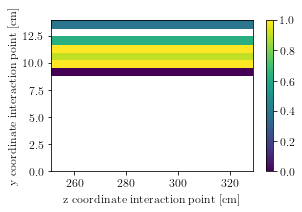

In [78]:
ax = set_canvas_basic()

selection = f'({tpc_active_volume_endpoints[2][0]}<int_point_z)&(int_point_z<{tpc_active_volume_endpoints[2][1]})'
ctaus_indexes = [0, 10, 15]
binning = (np.linspace(tpc_active_volume_endpoints[2][0], tpc_active_volume_endpoints[2][1], 2), 
           np.linspace(0, tpc_fiducial_volume_endpoints[1][0], 20))
hist_noctau = np.histogram2d(out_no_ctau[0].query(selection)['int_point_z'],
                                out_no_ctau[0].query(selection)['int_point_y'],
                                bins=binning, 
                                weights=out_no_ctau[1][out_no_ctau[0].eval(selection)])[0]

hist_ctau = np.histogram2d(out_ctau[0].query(selection)['int_point_z'],
                                out_ctau[0].query(selection)['int_point_y'],
                                bins=binning, 
                                weights=out_ctau[1][out_ctau[0].eval(selection), 0])[0]

im = ax.pcolormesh(*binning, (hist_ctau/hist_noctau).T)
plt.colorbar(im, ax=ax)
ax.set_xlabel('z coordinate interaction point [cm]')
ax.set_ylabel('y coordinate interaction point [cm]')
# ax.legend(frameon=False)
# ax.set_xlabel('x coordinate interaction point [cm]')
# ax.set_ylabel('Geometrical acceptance')
# ax.set_ylim(0, 1)

In [87]:
out_ctau[1][out_ctau[0].eval(selection), 0]

array([0.00000000e+00, 0.00000000e+00, 1.84779431e-06, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

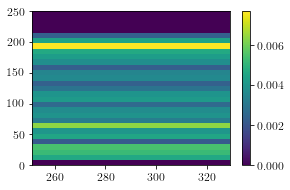

In [88]:
binning = (np.linspace(tpc_active_volume_endpoints[2][0], tpc_active_volume_endpoints[2][1], 2), 
           np.linspace(0, 250, 30))
hist_noctau = plt.hist2d(out_ctau[0].query(selection)['int_point_z'],
                         out_ctau[0].query(selection)['int_point_y'],
                         bins=binning,
                         weights=out_ctau[1][out_ctau[0].eval(selection), 0]
                        )[0]
plt.colorbar()

# Try again 2

In [125]:
# ctaus = np.geomspace(1e-2, 1e4, 21)
ctaus = np.array([1e-2, 1, 1e2])
nu_mode = 'FHC'
this_analysis = analyses['tpc'][nu_mode]

total_out = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                            my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                            m4=physics_parameters[hierarchy]['bp']['m4'], 
                            mz=physics_parameters[hierarchy]['bp']['mz'], 
                            alpha_dark=physics_parameters[hierarchy]['bp']['alpha_dark'], 
                            epsilon=physics_parameters[hierarchy]['bp']['epsilon'], 
                            Umu4_2=physics_parameters[hierarchy]['bp']['Umu4_2'], 
                            Ud4_2=None,
                            external_ctau=ctaus,
                            ntarget_per_material=this_analysis['n_target'], 
                            pot=this_analysis['pot'],
                            selection_query=this_analysis['selection'],
                            efficiency_factor=this_analysis['efficiency'],
                            out_different_weights=True)

In [126]:
ctau_weights = np.squeeze(total_out[1][2])

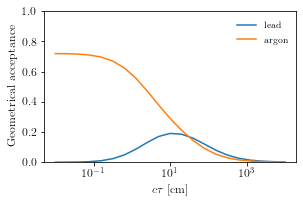

In [98]:
ax = set_canvas_basic()

for selection in ['lead', 'argon']:     
    acceptance = ctau_weights[total_out[0][selection], ...].mean(axis=0)
    ax.plot(ctaus, acceptance, label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.legend(frameon=False, loc='upper right')

# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

In [99]:
from scipy.stats import binned_statistic

(0.0, 1.0)

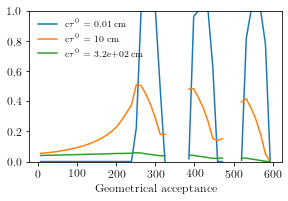

In [102]:
ax = set_canvas_basic()

ctaus_indexes = [0, 10, 15]
binning = np.linspace(0, 600, 50)
bin_centers = (binning[1:] + binning[:-1])/2
for index in ctaus_indexes:
    ys = binned_statistic(total_out[0]['int_point_z'], ctau_weights[:, index], statistic='mean', bins=binning)[0]
    ax.plot(bin_centers, ys, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')

ax.legend(frameon=False)
ax.set_xlabel('z coordinate interaction point [cm]')
ax.set_xlabel('Geometrical acceptance')
ax.set_ylim(0, 1)

(0.0, 1.0)

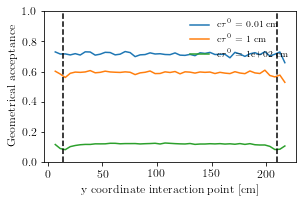

In [130]:
ax = set_canvas_basic()

selection = f'({tpc_active_volume_endpoints[2][0]}<int_point_z)&(int_point_z<{tpc_active_volume_endpoints[2][1]})'
# ctaus_indexes = [0, 10, 15]
ctaus_indexes = [0, 1, 2]
binning = np.linspace(0, p0d_dimensions[1], 50)
bin_centers = (binning[1:] + binning[:-1])/2
for index in ctaus_indexes:
    ys = binned_statistic(total_out[0].query(selection)['int_point_y'], 
                          ctau_weights[total_out[0].eval(selection), index], statistic='mean', bins=binning)[0]
    ax.plot(bin_centers, ys, label=f'c$\\tau^0$ = {ctaus[index]:.2g} cm')

ax.axvline(tpc_fiducial_volume_endpoints[1][0], linestyle='--', color='k')
ax.axvline(tpc_fiducial_volume_endpoints[1][1], linestyle='--', color='k')
ax.legend(frameon=False)
ax.set_xlabel('y coordinate interaction point [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_ylim(0, 1)

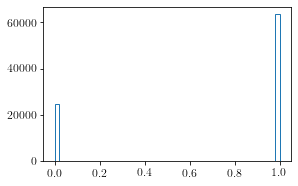

In [128]:
selection = f'({tpc_active_volume_endpoints[2][0]}<int_point_z)&(int_point_z<{tpc_active_volume_endpoints[2][1]})'
plt.hist(ctau_weights[total_out[0].eval(selection), 0], bins=50, histtype='step');

Text(0, 0.5, 'y coordinate interaction point [cm]')

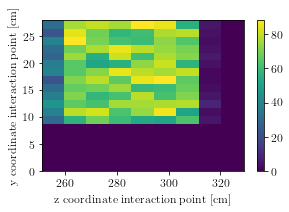

In [141]:
ax = set_canvas_basic()

selection_mask = ctau_weights[:, 0] > 0.5
binning = (np.linspace(tpc_active_volume_endpoints[2][0], tpc_active_volume_endpoints[2][1], 10), 
           np.linspace(0, 2*tpc_fiducial_volume_endpoints[1][0], 20))
hist = plt.hist2d(total_out[0][selection_mask]['int_point_z'],
                  total_out[0][selection_mask]['int_point_y'],
                  bins=binning, 
                  )[0]

plt.colorbar(ax=ax)
ax.set_xlabel('z coordinate interaction point [cm]')
ax.set_ylabel('y coordinate interaction point [cm]')

Text(0, 0.5, 'y coordinate interaction point [cm]')

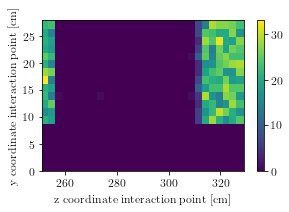

In [143]:
ax = set_canvas_basic()

selection_mask = ctau_weights[:, 0] < 0.5
binning = (np.linspace(tpc_active_volume_endpoints[2][0], tpc_active_volume_endpoints[2][1], 30), 
           np.linspace(0, 2*tpc_fiducial_volume_endpoints[1][0], 20))
hist = plt.hist2d(total_out[0][selection_mask]['int_point_z'],
                  total_out[0][selection_mask]['int_point_y'],
                  bins=binning, 
                  )[0]

plt.colorbar(ax=ax)
ax.set_xlabel('z coordinate interaction point [cm]')
ax.set_ylabel('y coordinate interaction point [cm]')

In [145]:
total_out[0].query(f'({tpc_fiducial_volume_endpoints[2][0]}<int_point_z)&(int_point_z<{tpc_fiducial_volume_endpoints[2][1]}) &\
                     ({tpc_active_volume_endpoints[1][0]}<int_point_y)&(int_point_y<{tpc_fiducial_volume_endpoints[1][0]})')

,weight,m4,mzprime,ee_mass,ee_energy,ee_momentum,ee_energy_asymetry,ee_costheta,ee_theta,ee_beam_costheta,...,unitary_decay_length_z,pdark_dir_x,pdark_dir_y,pdark_dir_z,exp_integral_points_0,exp_integral_points_1,exp_integral_points_2,exp_integral_points_3,exp_integral_points_4,exp_integral_points_5
5472767,1.270195e-75,0.072274,2.224979,0.039041,0.304141,0.301625,-0.274420,0.964387,0.267680,0.999601,...,2.804665,-0.002554,0.010153,0.999945,0.0,8.057145,88.261543,122.450645,0.000000,0.000000
5473332,6.969480e-75,0.063811,1.960807,0.044892,2.988084,2.987746,-0.722525,0.999057,0.043442,0.999954,...,208.618027,0.003090,-0.010523,0.999940,0.0,24.902338,105.107162,161.410553,241.615372,297.918762
5473731,2.176095e-78,0.005182,1.136364,0.002633,0.195276,0.195258,-0.888838,0.999511,0.031289,0.998619,...,0.289231,-0.044972,-0.027869,0.998599,0.0,25.677477,105.989960,162.368912,242.681396,299.060364
5474265,8.947247e-73,0.075001,1.018861,0.050778,2.289000,2.288436,-0.657134,0.998269,0.058847,0.998902,...,25.245571,-0.040906,0.013224,0.999075,0.0,18.457338,98.731552,155.083649,235.357864,291.709961
5474363,3.213316e-73,0.068934,1.350130,0.043224,0.266023,0.262488,-0.425032,0.935600,0.360840,0.996112,...,6.392259,-0.058246,0.030576,0.997834,0.0,10.575912,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363886,3.483148e-76,0.402038,8.466648,0.097578,1.770827,1.768136,-0.124410,0.993832,0.111121,0.998735,...,1.272152,-0.003812,-0.015038,0.999880,0.0,52.315556,132.525208,188.831985,269.041626,325.348419
6372803,1.233542e-75,0.410015,7.978593,0.149327,1.047065,1.036362,0.637062,0.931541,0.372169,0.996352,...,0.318997,0.060560,0.026886,0.997802,0.0,1.194684,81.571320,86.166397,0.000000,0.000000
6381525,1.420570e-76,0.395932,9.784586,0.221356,2.847357,2.838739,0.871468,0.949754,0.318346,0.998543,...,15.725619,0.017664,0.017127,0.999697,0.0,16.022652,0.000000,0.000000,0.000000,0.000000
6382154,2.824731e-76,0.408296,9.855701,0.210297,1.274936,1.257473,0.841152,0.813955,0.619868,0.992908,...,1.951533,0.023528,0.000099,0.999723,0.0,17.790012,0.000000,0.000000,0.000000,0.000000


# Older geometry plot

In [14]:
ctaus = np.geomspace(1e-2, 1e4, 3)

nu_mode = 'FHC'
aux = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=ctaus,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

aux_noctau = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=None,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

In [15]:
var1 = 'int_point_z'
var2 = 'int_point_y'

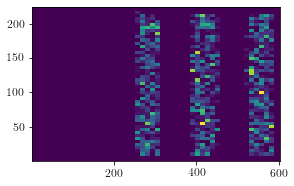

In [16]:
plt.hist2d(aux[0][var1], aux[0][var2], weights=aux[1][:, 0], bins=(50, 50));

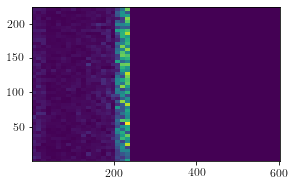

In [17]:
plt.hist2d(aux[0][var1], aux[0][var2], weights=aux[1][:, 1], bins=(50, 50));

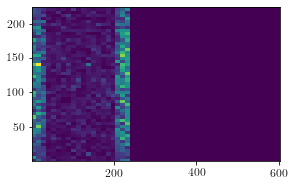

In [18]:
plt.hist2d(aux[0][var1], aux[0][var2], weights=aux[1][:, 2], bins=(50, 50));

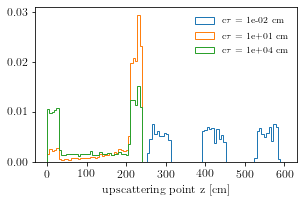

In [19]:
ax = set_canvas_basic()

for i, ctau in enumerate(ctaus):
    ax.hist(aux[0]['int_point_z'], 
            weights=aux[1][:, i], 
            density=True,
            histtype='step',
            bins=100,
            label=f'c$\\tau$ = {ctau:.0e} cm')
    
ax.legend(frameon=False, loc='upper right')
ax.set_xlabel('upscattering point z [cm]')
plt.savefig(save_folder+'upscattering_z.pdf', bbox_inches='tight')

<ipython-input-20-9d8fdcefd8b7>:5: RuntimeWarning: invalid value encountered in true_divide
  weights=np.nan_to_num(aux[1][:, i]/aux_noctau[1]),
<ipython-input-20-9d8fdcefd8b7>:5: RuntimeWarning: invalid value encountered in true_divide
  weights=np.nan_to_num(aux[1][:, i]/aux_noctau[1]),
<ipython-input-20-9d8fdcefd8b7>:5: RuntimeWarning: invalid value encountered in true_divide
  weights=np.nan_to_num(aux[1][:, i]/aux_noctau[1]),


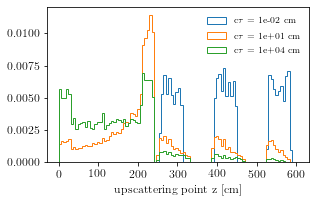

In [20]:
ax = set_canvas_basic()

for i, ctau in enumerate(ctaus):
    ax.hist(aux[0]['int_point_z'], 
            weights=np.nan_to_num(aux[1][:, i]/aux_noctau[1]), 
            density=True,
            histtype='step',
            bins=100,
            label=f'c$\\tau$ = {ctau:.0e} cm')
    
ax.legend(frameon=False, loc='upper right')
ax.set_xlabel('upscattering point z [cm]')
plt.savefig(save_folder+'upscattering_z_normalised.pdf', bbox_inches='tight')

# Number of events for different BPs as a function of $V_{ND}$ or c$\tau$

In [22]:
from posteriors import heavy_nonminimal_posterior_v

In [23]:
bps = [{'mz': 1.25, 'epsilon': 2.1e-2},
       {'mz': 1.25*0.5, 'epsilon': 2.1e-2*0.5},
       {'mz': 1.25*0.1, 'epsilon': 2.1e-2*0.1}]

In [24]:
V_ND_2_s = np.geomspace(2.2e-7, 1, 10)

out = []
for bp in bps:
    out.append(heavy_nonminimal_posterior_v(my_exp_analyses, Ud4_2=V_ND_2_s, ctau_mode='integral', **bp))

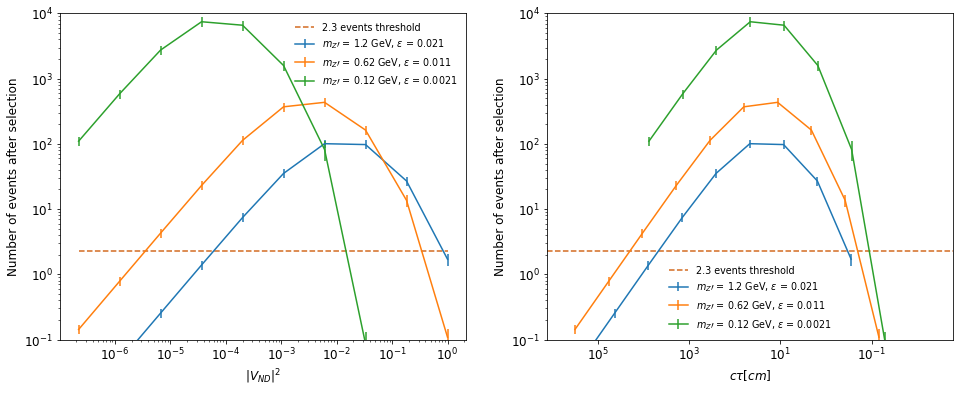

In [25]:
from scipy.interpolate import InterpolatedUnivariateSpline

test_points = np.geomspace(1e-5, 1, 30)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]
ax.set_xlabel('$|V_{ND}|^2$')
for bp, aux_out in zip(bps, out):
    ax.errorbar(V_ND_2_s, aux_out[1], yerr=np.sqrt(aux_out[2]),
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')
    
ax = axs[1]
ax.set_xlabel('$c \\tau [cm]$')
for bp, aux_out in zip(bps, out):
    ax.errorbar(aux_out[3], aux_out[1], yerr=np.sqrt(aux_out[2]),
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
ax.hlines(2.3, out[0][3][0], out[-1][3][-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')
ax.set_xlim(out[0][3][0], out[-1][3][-1])
    
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Number of events after selection')
    ax.set_ylim(0.1, 1e4)
    ax.legend(frameon=False, loc='best')

<ipython-input-65-0cf5d53b8319>:18: RuntimeWarning: divide by zero encountered in log
  ax.errorbar(np.log(V_ND_2_s)[mask], np.log(aux_out[1])[mask],
<ipython-input-65-0cf5d53b8319>:19: RuntimeWarning: divide by zero encountered in log
  yerr=np.log(np.sqrt(aux_out[2]))[mask], fmt=f'C{i} .',
<ipython-input-65-0cf5d53b8319>:23: RuntimeWarning: divide by zero encountered in log
  np.log(aux_out[1])[mask])(np.log(test_points)), f'C{i}')


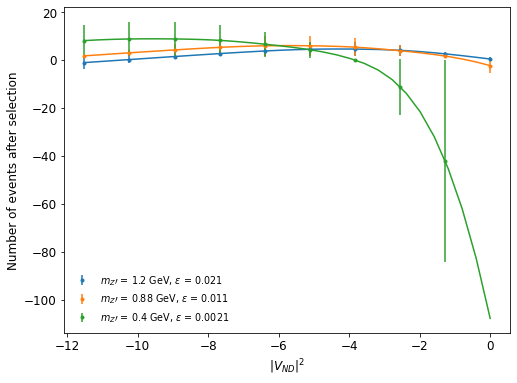

In [65]:
from scipy.interpolate import InterpolatedUnivariateSpline

test_points = np.geomspace(1e-5, 1, 30)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')

for i, (bp, aux_out) in enumerate(zip(bps, out)):
    mask = aux_out[1] != 0
    ax.errorbar(np.log(V_ND_2_s)[mask], np.log(aux_out[1])[mask], 
                yerr=np.log(np.sqrt(aux_out[2]))[mask], fmt=f'C{i} .',
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
    ax.plot(np.log(test_points), 
            InterpolatedUnivariateSpline(np.log(V_ND_2_s)[mask], 
                                         np.log(aux_out[1])[mask])(np.log(test_points)), f'C{i}')
ax.legend(frameon=False, loc='best')
# ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

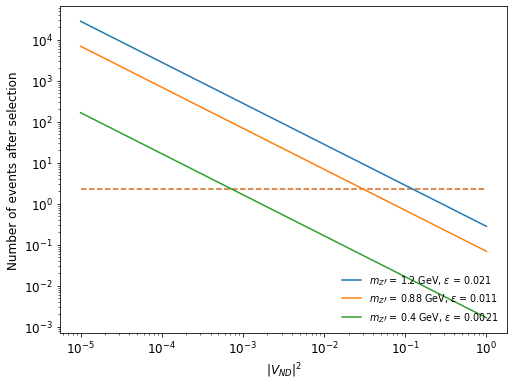

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')

ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')

ax.set_yscale('log')

for bp, aux_out in zip(bps, out):
    ax.errorbar(V_ND_2_s, aux_out[3], 
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")

ax.legend(frameon=False, loc='best')
ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

## Slider for physics distributions

In [ ]:
@interact(var=widgets.Dropdown(
                options=list(my_exp_analysis.df_base.columns.to_frame().loc[:, 0].values),
                description='Variable:',
                disabled=False,
            ),
          bins=widgets.IntSlider(min=1, max=50, step=1, value=10, continuous_update=False),
          hist_range=widgets.FloatRangeSlider(
                value=[0, 5],
                min=0,
                max=1e10,
                step=0.1,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
          m4=widgets.FloatSlider(min=0.005, max=1, step=0.025, value=0.3, continuous_update=False), 
          mz=widgets.FloatSlider(min=0.005, max=10, step=0.005, value=2, continuous_update=False), 
          ctau=widgets.FloatLogSlider(
                base=10,
                min=-2, # max exponent of base
                max=3, # min exponent of base
                step=0.2, # exponent step
                value=25,
            ),
          kernel=widgets.Dropdown(
                options=['epa', 'gaus'],
                description='Kernel type:',
                disabled=False,
            ),
          smooth_m4=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.03, continuous_update=False), 
          smooth_mz=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.005, continuous_update=False), 
          selection_step=widgets.RadioButtons(
                options=['no_selection', 'cut_based', 'geometric', 'geometric_cut_based'],
                value='no_selection',
                description='selection:',
            ),
          df=fixed(my_exp_analysis.df_base),
         exp_analysis = fixed(my_exp_analysis))

def output_distrib(exp_analysis, df, var, bins, hist_range, m4, mz, ctau, kernel, smooth_m4, smooth_mz, selection_step):
    
    m4_values = df['m4'].values
    mz_values = df['mzprime'].values
    df_values = np.stack([m4_values, mz_values], axis=-1)
    this_kde_weights = exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])
    weight_values = this_kde_weights * df['actual_weight'].values

    if selection_step == 'no_selection':
        pass
    if 'cut_based' in selection_step:
        weight_values *= df['cut_based'].values
    if 'geometric' in selection_step:
        exp_analysis.decay_in_tpc(df, ctau)
        weight_values *= df[f'decay_in_tpc_{ctau}']

    plt.hist(df[var],
             range=hist_range,
             bins=bins,
             weights=weight_values,
             histtype='step',
             label=f'kde2D, from $m_4$ in [{m4_values.min():.2g}, {m4_values.max():.2g}], $m_Z$ in [{mz_values.min():.2g}, {mz_values.max():.2g}]\nexpected events = {weight_values.sum():.1f}')
    plt.ylim(bottom=0)
    plt.xlabel(f"{var}")
    plt.ylabel(f"Expected number of entries / {(hist_range[1]-hist_range[0])/bins:.2g}")
    plt.title(f"$m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV, $c\\tau$ = {ctau:.2g} cm\n$\sigma_{{m_4}}$ = {smooth_m4:.2g} GeV, $\sigma_{{m_Z}}$ = {smooth_mz:.2g} GeV\nselection step = {selection_step}, expected events = {weight_values.sum():.1f}")
    return weight_values.sum()

## Distribution of events throughout detector

In [ ]:
ctau = 20
m4 = 0.1
mz = 1.25

m4_values = my_exp_analysis.df_base['m4'].values
mz_values = my_exp_analysis.df_base['mzprime'].values
df_values = np.stack([m4_values, mz_values], axis=-1)
smooth_m4, smooth_mz = 0.005, 0.05
this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

variable_1 = ('int_point_y')
variable_2 = ('int_point_z')
selection_step = 'no_selection'
        
my_exp_analysis.decay_in_tpc(my_exp_analysis.df_base, ctau)

if selection_step not in 'no_selection':
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[selection_step].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values
else:
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values        


In [ ]:
x,y = my_exp_analysis.df_base[variable_1], my_exp_analysis.df_base[variable_2]
points = np.array([x,y]).T
grid_x, grid_y = np.mgrid[np.min(x):np.max(x):10j, np.min(y):np.max(y):20j]
grid_z0 = griddata(points, weight_values, (grid_x, grid_y), method='linear')

In [ ]:
x,y,z = my_exp_analysis.df_base['int_point_x'], my_exp_analysis.df_base['int_point_y'], my_exp_analysis.df_base['int_point_z']

In [ ]:
plt.scatter(x,z,c=weight_values)

In [ ]:
plt.imshow(grid_z0, origin='lower')

# plt.scatter(x,y,c=)

plt.legend(frameon=False)
plt.xlabel(f'{variable_1} (cm)')
plt.ylabel(f'{variable_2} (cm)')

## Study N events vs ctau

In [ ]:
from ctau_utils import ctau_heavy
BP = {'m4': 0.12, 'mz': 1.25}

In [11]:
epsilons = np.geomspace(5e-5, 1e-1, 50)
Ud4_2s = [1, 1e-2, 1e-4]

In [12]:
exp_analysis = my_exp_analyses[hierarchy + '_' + D_or_M + '_FHC']

In [13]:
exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']))

(9923.296989790155, 20458.354586056925)

In [14]:
ctau = ctau_heavy(BP['m4'], BP['mz'], 0.01 * exp_analysis.alpha_dark * alphaQED * exp_analysis.epsilon2, D_or_M)
exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']), ctau=ctau)

(1120.931732224157, 2569.9975880555594)

In [15]:
# compute nevents
n_events_base = []
for epsilon in epsilons:
    n_events_base.append(exp_analysis.kde_n_events(exp_analysis.df_base, 
                                                   (BP['m4'], BP['mz']), 
                                                   mu=epsilon**2/exp_analysis.epsilon2)[0])
n_events_decay = {}
ctaus_ud4 = {}
for Ud4_2 in Ud4_2s: 
    n_events_decay[Ud4_2] = []
    ctaus_ud4[Ud4_2] = []
    for epsilon in epsilons:
        Valpha4_alphaepsilon2 = Ud4_2 * exp_analysis.alpha_dark * alphaQED * epsilon**2
        ctau = ctau_heavy(BP['m4'], BP['mz'], Valpha4_alphaepsilon2, D_or_M)
        ctaus_ud4[Ud4_2].append(ctau)
        n_events_decay[Ud4_2].append(exp_analysis.kde_n_events(exp_analysis.df_base, 
                                                   (BP['m4'], BP['mz']), 
                                                   ctau=ctau,
                                                   mu=epsilon**2/exp_analysis.epsilon2)[0])

In [16]:
# compute efficiency vs ctau
ctaus = np.geomspace(1e-3, 1e8, 50)
eff_vs_ctau = []
n_events_no_geom = exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']))[0]
for ctau in ctaus:
    eff_vs_ctau.append(exp_analysis.kde_n_events(exp_analysis.df_base,
                                                   (BP['m4'], BP['mz']),
                                                   ctau=ctau)[0]/n_events_no_geom)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


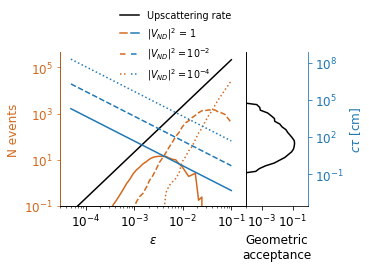

In [17]:
color_ctau = 'C0'
color_rate = 'chocolate'
fig, ax = plt.subplots(ncols=2,
                       nrows=1,
#                        figsize=(4.44, 3.2),
                       sharey='none',
                       gridspec_kw={'width_ratios':[3, 1]})

up_scattering_rate_line, = ax[0].plot(epsilons, n_events_base, label='Upscattering rate', color='black')
ax2 = ax[0].twinx()
ax[1].get_shared_y_axes().join(ax[1], ax2)
fig.subplots_adjust(wspace=0)

ax[0].loglog()  
ax[0].set_ylim(bottom=0.1)
ax[0].set_xlim(3e-5, 2e-1)

ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('N events', color=color_rate)
ax[0].tick_params(axis='y', colors=color_rate, which='both')
ax2.spines['left'].set_color(color_rate) 

ax[1].loglog()
ax[1].set_xlim(9e-5, 1)
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].yaxis.tick_right()
ax[1].tick_params(axis='y', colors=color_ctau)
ax[1].yaxis.set_label_position("right")
ax[1].spines['right'].set_color(color_ctau)  
ax[1].set_ylabel(r'$c \tau$ [cm]', color=color_ctau)
ax[1].set_xticks([1e-3, 1e-1])
ax[1].set_xlabel('Geometric\nacceptance')
ax[1].spines['top'].set_visible(False)

linestyles = ['-', '--', 'dotted', '-.']
rate_lines = {}
ctau_lines = {}
for Ud4_2, linestyle in zip(Ud4_2s, linestyles): 
    rate_lines[Ud4_2], = ax[0].plot(epsilons, n_events_decay[Ud4_2], 
                      color=color_rate, linestyle=linestyle)
    ctau_lines[Ud4_2], = ax2.plot(epsilons, ctaus_ud4[Ud4_2], '--', color=color_ctau, linestyle=linestyle)
    
ax[0].legend([up_scattering_rate_line] + list(zip(rate_lines.values(), ctau_lines.values())),
             ['Upscattering rate'] + [f'$|V_{{ND}}|^2$ = {Ud4_2}' if Ud4_2==1 else r'$|V_{{ND}}|^2 = 10^{'+f'{np.log10(Ud4_2):.1g}'+r'}$'
              for Ud4_2 in Ud4_2s],
             frameon=False, loc=(0.3, 0.78), 
             numpoints=1,
             handler_map={tuple: HandlerTuple(ndivide=None)})

ax[1].plot(eff_vs_ctau, ctaus, color='black')
plt.savefig(save_folder + 'n_events_vs_ctau.pdf', bbox_inches='tight', transparent=True)
plt.savefig(save_folder + 'n_events_vs_ctau.png', dpi=250, bbox_inches='tight', transparent=True)

## Study the simulation of the geometry

In [7]:
ctaus = [0.1, 1, 10, 100]

0.1


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


1
10
100
0.1


KeyError: 'decay_point_0.1_x'

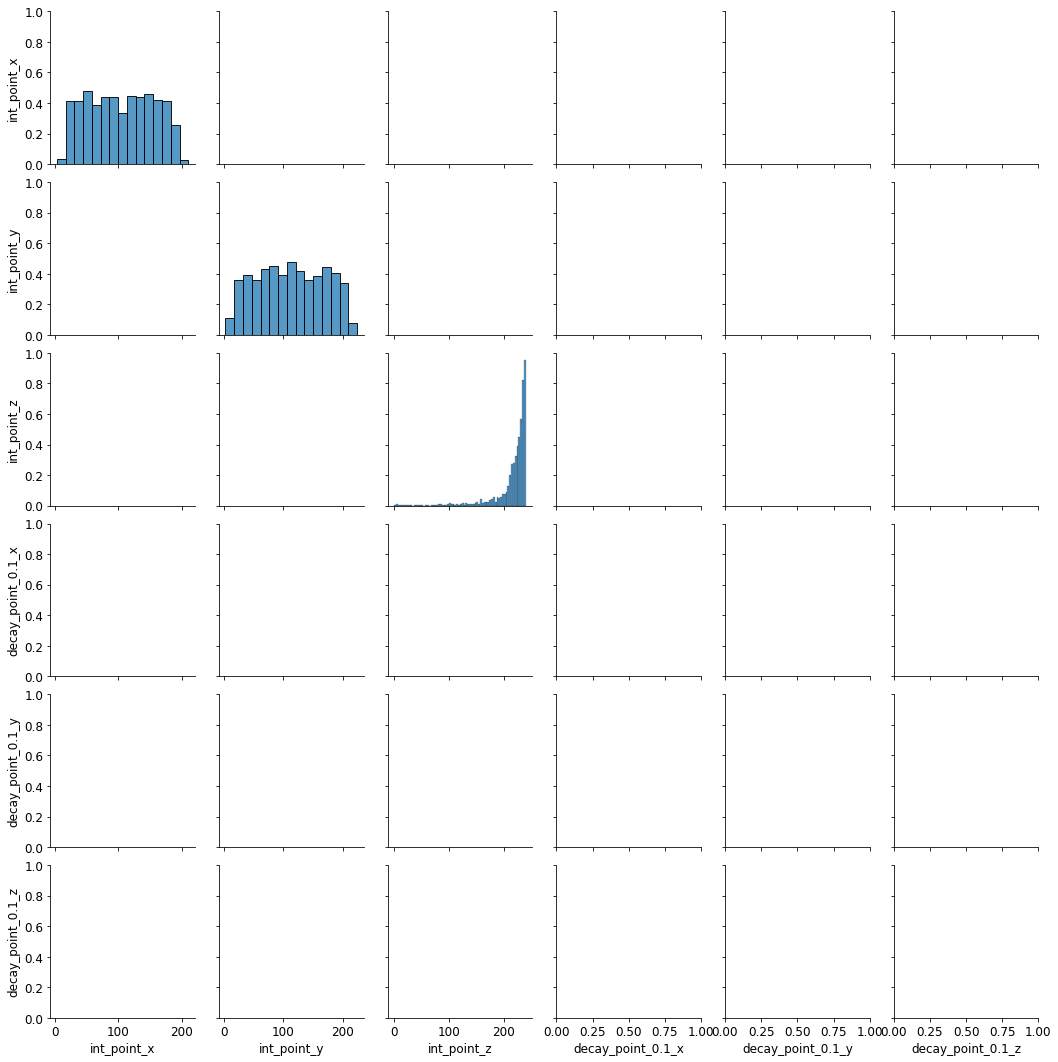

In [9]:
# old method
for key, exp_analysis in my_exp_analyses.items():
    exp_analysis.decay_in_tpc(exp_analysis.df_base, ctaus)
    for ctau in ctaus:
        print(ctau)
        sns.pairplot(exp_analysis.df_base.query(f'decay_in_tpc_{ctau}'.replace('.', '')).sample(2000), 
                     vars=['int_point_x', 'int_point_y', 'int_point_z',
                               f'decay_point_{ctau}_x', f'decay_point_{ctau}_y', f'decay_point_{ctau}_z',],)
#                      hue='material')
        plt.suptitle(key.replace('_', ' ') + f'$c\tau$ = {ctau} cm')
        plt.savefig(save_folder + f'geometry_2d_plot_ctau_{ctau}_{key}'.replace('.', '')+'.pdf', bbox_inches='tight')
        plt.close()

# Event rate in the light case in the FGD

In [7]:
from parameters_dict import *

In [8]:
selection = 'carbon'
exp_analysis = my_exp_analyses['light_majorana']
m4mz = (0.1, 0.03)
smoothing_pars = [0.1, 0.1]
mu = 0.25 * 8e-9 / exp_analysis.alpha_dark / exp_analysis.Umu4
mass_ratio = 1848.6 * 1e-9 * 184**2  * 15 / mass_material[selection]

(0.0, 29.34573481968772)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


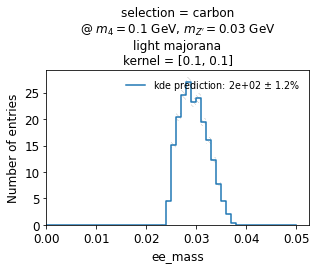

In [9]:
kde_variable_plot(var='ee_mass', 
                  range=[0, 0.05], 
                  bins=50,
                  m4mz=m4mz,
                  exp_analysis_obj=exp_analysis,
                  smoothing_pars=smoothing_pars,
                  selection_query=selection,
                  additional_scaling=mu*mass_ratio)
plt.xlim(left=0)
plt.ylim(bottom=0)

(0.0, 0.8706491813249865)

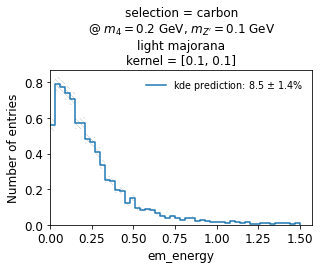

In [13]:
kde_variable_plot(var='em_energy', 
                  range=[0, 1.5], 
                  bins=50, 
                  m4mz=m4mz, 
                  exp_analysis_obj=exp_analysis, 
                  smoothing_pars=smoothing_pars, 
                  selection_query=selection,
                  additional_scaling=mu*mass_ratio)
plt.xlim(left=0)
plt.ylim(bottom=0)

(0.0, 452.89945255324636)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


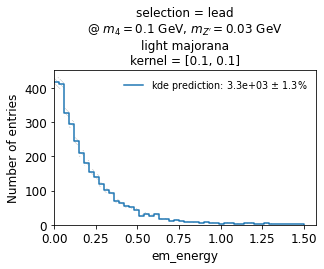

In [9]:
kde_variable_plot(var='em_energy', 
                  range=[0, 1.5], 
                  bins=50, 
                  m4mz=m4mz, 
                  exp_analysis_obj=exp_analysis, 
                  smoothing_pars=smoothing_pars, 
                  selection_query='lead',
                  additional_scaling=mu*0.5)
plt.xlim(left=0)
plt.ylim(bottom=0)

In [25]:
selection = 'carbon'
exp_analysis = my_exp_analyses['light_majorana']
m4mz = (0.2, 0.1)
smoothing_pars = [0.1, 0.1]
mu = 0.25 * 8e-9 / exp_analysis.alpha_dark / exp_analysis.Umu4
mass_ratio = 1848.6 * 1e-9 * 184**2  * 15 / mass_material[selection]

In [36]:
m4_s = np.asarray([0.1, 0.25, 0.42])
mz_s = np.linspace(0.005, 0.195, 20)

In [39]:
m4_mu = {}
m4_sigma2 = {}
for m4 in m4_s:
    m4_mu[m4] = []
    m4_sigma2[m4] = []
    for mz in mz_s:
        kde_weights = exp_analysis.kde_on_a_point(exp_analysis.df_base.query('carbon'),
                                                  this_m4mz=(m4, mz),
                                                  smoothing=smoothing_pars) * mu * mass_ratio
        m4_mu[m4].append(kde_weights.sum())
        m4_sigma2[m4].append((kde_weights**2).sum())

Text(0.5, 1.0, 'BP-L2, carbon only in the FGD\nno selection, 2e20 POT')

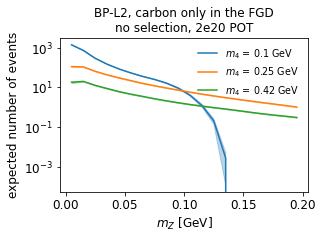

In [41]:
for m4 in m4_s:
    aux_line = plt.plot(mz_s, m4_mu[m4], label=f'$m_4$ = {m4} GeV')
    plt.fill_between(mz_s, m4_mu[m4]-np.sqrt(m4_sigma2[m4]),
                           m4_mu[m4]+np.sqrt(m4_sigma2[m4]),
                    color=aux_line[0].get_color(), alpha=0.3)
    
plt.ylabel('expected number of events')
plt.xlabel('$m_Z$ [GeV]')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('BP-L2, carbon only in the FGD\nno selection, 2e20 POT')

## Event rate vs ee energy for different ctaus

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from matplotlib.patches import FancyArrowPatch

In [ ]:
def plot_var_postsel_and_cut(myexp, variable, m4, mz, ctaus, \
                             selection_step='no_cuts', 
                             smooth_m4=0.005, 
                             smooth_mz=0.05, 
                             label_x='x',
                             bins=10,
                             xrange=(0,5),
                             colors=None,
                             left_cut=None,
                             right_cut=None,
                             normed=False):
    
    fsize=11
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
    params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
                'figure.figsize':(1.5*3,1.5*2.4)	}
    rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
    plt.rcParams['hatch.linewidth'] = 0.3
    rcParams.update(params)
    axes_form  = [0.14,0.17,0.82,0.74]
    fig = plt.figure()
    ax = fig.add_axes(axes_form)
        
    m4_values = myexp.df_base['m4'].values
    mz_values = myexp.df_base['mzprime'].values
    
    df_values = np.stack([m4_values, mz_values], axis=-1)
    
    this_kde_weights = myexp.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

    myexp.decay_in_tpc(myexp.df_base, ctaus)
    
    for ctau in ctaus:
        weight_values = this_kde_weights *\
                        myexp.df_base['actual_weight'].values *\
                        myexp.df_base[selection_step].values *\
                        myexp.df_base[f'decay_in_tpc_{ctau}'].values

        if colors is not None:
            color=colors[ctaus.index(ctau)]
        else:
            color='black'
            
        out = plt.hist(myexp.df_base[variable], 
                       bins=bins, 
                       range=xrange,
                       weights=weight_values, 
                       label=f"ctau = {ctau} cm, nevt = {weight_values.sum():.0f} $\pm$ {np.sqrt((weight_values**2).sum()):.0f}", 
                       histtype='step',
                       lw=1.5,
                      density=normed,
                      color=color)

    y1, y2 = ax.get_ylim()
    x1, x2 = ax.get_xlim()

    if left_cut is not None:
        leftArrow = FancyArrowPatch(posA=(left_cut-(x2-x1)/15, (y2-y1)*0.8), posB=(left_cut, (y2-y1)*0.8), arrowstyle='<|-',
                          mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(leftArrow)
        ax.axvline(left_cut,c='black')

    if right_cut is not None:
        rightArrow = FancyArrowPatch(posA=(right_cut, (y2-y1)*0.8), posB=(right_cut+(x2-x1)/15, (y2-y1)*0.8), arrowstyle='-|>',
                              mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(rightArrow)
        ax.axvline(right_cut,c='black')

    plt.legend(frameon=False)
    ax.set_xlabel(label_x)
    return fig, ax


In [ ]:
ctaus = [0.1, 1, 10, 100]
colors = ['blue', 'green', 'orange', 'purple', 'red']

m4 = 0.12
mz = 1.25

variable = ('ee_momentum')
selection_step = 'cut_based'
cut=0.150
plot_var_postsel_and_cut(my_exp_analysis, 'ee_energy', m4, mz, ctaus, 
                         selection_step, 
                         smooth_m4=0.05, 
                         smooth_mz=0.1, 
                         left_cut=2.5,
                        colors=colors)
#                         right_cut=0.8)